In [1]:
import os, findspark

#  Spark 4.0.1
os.environ["SPARK_HOME"] = "/opt/spark-4.0.1-bin-hadoop3"
os.environ["PATH"] = os.path.join(os.environ["SPARK_HOME"], "bin") + ":" + os.environ["PATH"]


findspark.init("/opt/spark-4.0.1-bin-hadoop3")

# create Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("JobPostingsAnalysis").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/05 02:21:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load CSV file into Spark DataFrame

df = (
    spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .option("multiLine", "true")
        .option("escape", "\"")
        .csv("../data/lightcast_job_postings.csv")
)

In [3]:
from pyspark.sql import functions as F

# Remove rows with missing SALARY
df = df.filter(F.col("SALARY").isNotNull())

# Remove duplicates based on key job-identifying fields
df = df.dropDuplicates(
    subset=[
        "CITY_NAME",
        "COUNTY_NAME",
        "STATE_NAME",
        "TITLE_CLEAN",
        "COMPANY_RAW",
        "POSTED"
    ]
)


print("Rows after cleaning:", df.count())

Rows after cleaning: 30613


In [4]:
from pyspark.sql import functions as F

df = df.withColumn(
    "EMPLOYMENT_TYPE_NAME",
    F.when(F.col("EMPLOYMENT_TYPE_NAME").like("%Part-time / full-time%"), "Flexible")
     .when(F.col("EMPLOYMENT_TYPE_NAME").like("%Full-time%"), "Full-time")
     .when(F.col("EMPLOYMENT_TYPE_NAME").like("%Part-time%"), "Part-time")
     .otherwise(None)
)

In [5]:
from pyspark.sql import functions as F

df = df.withColumn(
    "EDUCATION_LEVELS_NAME",
    F.regexp_replace(F.col("EDUCATION_LEVELS_NAME"), r"[\\[\\]\"]", "")
)

df = df.withColumn(
    "EDUCATION_LEVELS_NAME",
    F.when(F.col("EDUCATION_LEVELS_NAME").rlike("PhD|Doctorate|Professional"), "PhD")
     .when(F.col("EDUCATION_LEVELS_NAME").rlike("Master"), "Master")
     .when(F.col("EDUCATION_LEVELS_NAME").rlike("Bachelor"), "Bachelor")
     .when(F.col("EDUCATION_LEVELS_NAME").rlike("Associate|GED|No Education Listed|High School"),
           "Associate or Lower")
     .otherwise("Other")
)


In [6]:
from pyspark.sql import functions as F

df = df.withColumn(
    "REMOTE_TYPE_NAME",
    F.when(F.col("REMOTE_TYPE_NAME").like("%Hybrid%"), "Hybrid")
     .when(F.col("REMOTE_TYPE_NAME").like("%Remote%"), "Remote")
     .otherwise("Onsite")
)

### **Regroup STATE_NAME**

1. Northeast:

CT, ME, MA, NH, RI, VT, NJ, NY, PA

2. Midwest:

IL, IN, MI, OH, WI, IA, KS, MN, MO, NE, ND, SD

3. South:

DE, FL, GA, MD, NC, SC, VA, WV, DC, AL, KY, MS, TN, AR, LA, OK, TX

4. West:

AZ, CO, ID, MT, NV, NM, UT, WY, AK, CA, HI, OR, WA

In [7]:
from pyspark.sql.functions import when, col

df = df.withColumn(
    "STATE_REGION",
    when(col("STATE_NAME").isin(
        "Connecticut", "Maine", "Massachusetts", "New Hampshire", 
        "Rhode Island", "Vermont", "New Jersey", "New York", "Pennsylvania"
    ), "Northeast")
    .when(col("STATE_NAME").isin(
        "Illinois", "Indiana", "Michigan", "Ohio", "Wisconsin",
        "Iowa", "Kansas", "Minnesota", "Missouri", 
        "Nebraska", "North Dakota", "South Dakota"
    ), "Midwest")
    .when(col("STATE_NAME").isin(
        "Delaware", "Florida", "Georgia", "Maryland", "North Carolina", 
        "South Carolina", "Virginia", "West Virginia", "Washington, D.C. (District of Columbia)",
        "Alabama", "Kentucky", "Mississippi", "Tennessee",
        "Arkansas", "Louisiana", "Oklahoma", "Texas"
    ), "South")
    .when(col("STATE_NAME").isin(
        "Arizona", "Colorado", "Idaho", "Montana", "Nevada",
        "New Mexico", "Utah", "Wyoming",
        "Alaska", "California", "Hawaii", "Oregon", "Washington"
    ), "West")
    .otherwise("Unknown")
)

df.select("STATE_NAME", "STATE_REGION").show(100, truncate=False)

+--------------+------------+
|STATE_NAME    |STATE_REGION|
+--------------+------------+
|Minnesota     |Midwest     |
|Oklahoma      |South       |
|California    |West        |
|Washington    |West        |
|Nebraska      |Midwest     |
|Florida       |South       |
|California    |West        |
|North Carolina|South       |
|California    |West        |
|California    |West        |
|California    |West        |
|Texas         |South       |
|New York      |Northeast   |
|Ohio          |Midwest     |
|Washington    |West        |
|Hawaii        |West        |
|New Jersey    |Northeast   |
|Michigan      |Midwest     |
|California    |West        |
|Oregon        |West        |
|New Jersey    |Northeast   |
|Texas         |South       |
|Texas         |South       |
|Missouri      |Midwest     |
|Georgia       |South       |
|Illinois      |Midwest     |
|California    |West        |
|Connecticut   |Northeast   |
|Iowa          |Midwest     |
|Kansas        |Midwest     |
|Texas    

In [8]:
from pyspark.sql import functions as F

# Step 1: compute median
median_value = df.approxQuantile("MIN_YEARS_EXPERIENCE", [0.5], 0.01)[0]

# Step 2: fill missing with median
df = df.withColumn(
    "MIN_YEARS_EXPERIENCE",
    F.when(F.col("MIN_YEARS_EXPERIENCE").isNull(), median_value)
     .otherwise(F.col("MIN_YEARS_EXPERIENCE"))
)


In [9]:
df.show(5)
len(df.columns)

25/12/05 02:22:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+----------+--------+--------------------+--------------------+--------------------+-----------+-------------------+---------+--------------------+---------------+----------------+--------+------------------+--------------------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+--------------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--

132

In [10]:
df.printSchema() 

root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = false)
 |-- MIN_EDULEVELS: integer 

In [11]:
columns_to_drop = [
    "ID", "URL", "ACTIVE_URLS", "DUPLICATES", "LAST_UPDATED_TIMESTAMP",
    "NAICS2", "NAICS3", "NAICS4", "NAICS5", "NAICS6",
    "SOC_2", "SOC_3", "SOC_4", "SOC_5",
    "NAICS_2022_2", "NAICS_2022_3","NAICS_2022_4","NAICS_2022_5",
    "NAICS_2022_2_NAME","NAICS_2022_3_NAME","NAICS_2022_4_NAME","NAICS_2022_5_NAME",
    "SOC_5_NAME","SOC_4_NAME","SOC_3_NAME","SOC_2_NAME",
    "NAICS2_NAME","NAICS3_NAME","NAICS4_NAME","NAICS5_NAME",
    "LAST_UPDATED_DATE","EXPIRED","DURATION",    # date variables are not related to our topic 
    "MODELED_EXPIRED","MODELED_DURATION","MODELED_EXPIRED",
    "COMPANY", "TITLE", "SKILLS",                  # remove numerical COMPANY
    "MAX_EDULEVELS","MAX_EDULEVELS_NAME",
    "EMPLOYMENT_TYPE","REMOTE_TYPE", "EMPLOYMENT_TYPE",     # remove numerical EMPLOYMENT_TYPE, REMOTE_TYPE, keeping the text version
    "LOCATION", "CITY","COUNTY","MSA","STATE", 
    "MSA_NAME", "COUNTY_NAME_OUTGOING", "COUNTY_NAME_INCOMING", "MSA_NAME_OUTGOING", "MSA_NAME_INCOMING",   
    "COUNTY_OUTGOING","COUNTY_INCOMING", "MSA_OUTGOING", "MSA_INCOMING",         # LOCATION contains latitude and longitude coordinates, CITY ontains encoded strings instead of actual city names 
    "EDUCATION_LEVELS", "MIN_EDULEVELS",  # encoded strings instead of actual EDUCATION_LEVELS, we keep EDUCATION_LEVELS_NAME. MIN_EDULEVELS contains number 
    "SPECIALIZED_SKILLS", "CERTIFICATIONS", "COMMON_SKILLS", "SOFTWARE_SKILLS",    # encoded strings
    "SOC_2021_2", "SOC_2021_2_NAME", "SOC_2021_3", "SOC_2021_3_NAME", "SOC_2021_5", "SOC_2021_5_NAME",
    "LOT_CAREER_AREA", "LOT_OCCUPATION", "LOT_SPECIALIZED_OCCUPATION", "LOT_OCCUPATION_GROUP","LOT_V6_SPECIALIZED_OCCUPATION", "LOT_V6_CAREER_AREA", "LOT_V6_OCCUPATION_GROUP",  
    "ACTIVE_SOURCES_INFO", "MAX_YEARS_EXPERIENCE", "LIGHTCAST_SECTORS", "LIGHTCAST_SECTORS_NAME", "ORIGINAL_PAY_PERIOD",   # missing values >50%
    "SOURCE_TYPES", "SOURCES", "BODY", 
    "COMPANY_NAME", "TITLE_NAME",  #keep  COMPANY_RAW and TITLE_CLEAN (simplified version)
    "ONET", "ONET_2019","CIP6", "CIP4", "CIP2",       # numerical 
    "CIP6_NAME","CIP4_NAME","CIP2_NAME",     # remove zipcode-related variables, we keep location name from state to county
    
] 

df = df.drop(*columns_to_drop)

In [12]:
df.show(5)

len(df.columns)

+---------+---------+--------------------+-------------------+---------------------+-------------------+--------------------+--------------------+-------------+------+----------------+---------+-----------+--------------------+--------------+----------+--------------------+-----------+--------------------+-----------------------+-------------------+--------------------+--------------------+--------------------+--------------------+----------+---------------+--------------------+--------------------+-------------------------------+-------------------------+----------------------------------+-----------------+----------------------+----------------------------+-----------------------+------------+--------------------+------------+
|   POSTED|TITLE_RAW|         COMPANY_RAW|COMPANY_IS_STAFFING|EDUCATION_LEVELS_NAME| MIN_EDULEVELS_NAME|EMPLOYMENT_TYPE_NAME|MIN_YEARS_EXPERIENCE|IS_INTERNSHIP|SALARY|REMOTE_TYPE_NAME|SALARY_TO|SALARY_FROM|           CITY_NAME|   COUNTY_NAME|STATE_NAME|        

39

In [13]:
from pyspark.sql import functions as F

total_rows = df.count()

exprs = [
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]

missing_row = df.agg(*exprs).collect()[0].asDict()

missing_stats = [(col, missing_row[col], missing_row[col] / total_rows)
                 for col in df.columns]

missing_df = spark.createDataFrame(
    missing_stats,
    ["column", "missing_count", "missing_ratio"]
)

missing_df.orderBy("missing_ratio", ascending=False).show(60)

+--------------------+-------------+--------------------+
|              column|missing_count|       missing_ratio|
+--------------------+-------------+--------------------+
|         COMPANY_RAW|          226|0.007382484565380...|
|         TITLE_CLEAN|           51|0.001665958906346...|
|           TITLE_RAW|           23|7.513148009015778E-4|
|SPECIALIZED_SKILL...|            0|                 0.0|
|              POSTED|            0|                 0.0|
| CERTIFICATIONS_NAME|            0|                 0.0|
| COMPANY_IS_STAFFING|            0|                 0.0|
|  COMMON_SKILLS_NAME|            0|                 0.0|
|EDUCATION_LEVELS_...|            0|                 0.0|
|SOFTWARE_SKILLS_NAME|            0|                 0.0|
|  MIN_EDULEVELS_NAME|            0|                 0.0|
|           ONET_NAME|            0|                 0.0|
|EMPLOYMENT_TYPE_NAME|            0|                 0.0|
|      ONET_2019_NAME|            0|                 0.0|
|MIN_YEARS_EXP

# **1. Unsupervised Learning**

In [14]:
cols = [
    "SALARY",
    "MIN_EDULEVELS_NAME",
    "MIN_YEARS_EXPERIENCE",
    "EMPLOYMENT_TYPE_NAME",
    "IS_INTERNSHIP",
    "REMOTE_TYPE_NAME",
    "STATE_REGION"
]


print(df[cols].dtypes)


[('SALARY', 'int'), ('MIN_EDULEVELS_NAME', 'string'), ('MIN_YEARS_EXPERIENCE', 'double'), ('EMPLOYMENT_TYPE_NAME', 'string'), ('IS_INTERNSHIP', 'boolean'), ('REMOTE_TYPE_NAME', 'string'), ('STATE_REGION', 'string')]


We selected **salary (SALARY)**, **minimum education level (MIN_EDULEVELS_NAME)**, **minimum years of experience (MIN_YEARS_EXPERIENCE)**, **employment type (EMPLOYMENT_TYPE_NAME)**, **internship status (IS_INTERNSHIP)**, **work modality (REMOTE_TYPE_NAME)**, and **geographic region (STATE_REGION)** as the core features for our KMeans clustering analysis. These variables collectively capture the essential structural dimensions of job postings—compensation, qualification requirements, employment characteristics, and geographic context—allowing the clustering algorithm to identify meaningful job-type patterns across the labor market. Since all selected features represent job-level attributes, they effectively reflect role-specific differences and are well suited for unsupervised learning

1. **SALARY**: Captures compensation level and serves as the primary indicator for distinguishing high-, mid-, and low-paying roles.
2. **MIN_EDULEVELS_NAME**: Represents the minimum educational requirement, helping distinguish roles based on specialization and skill thresholds.
3. **MIN_YEARS_EXPERIENCE**: Measures experience requirements and enables separation of entry-level, mid-level, and senior positions.
4. **EMPLOYMENT_TYPE_NAME**: Differentiates full-time, part-time, and contract roles, reflecting variations in job stability and employment structure.
5. **IS_INTERNSHIP**: Identifies internship positions, which differ substantially from regular jobs in experience level and compensation.
6. **REMOTE_TYPE_NAME**: Captures whether a job is remote, hybrid, or onsite—an increasingly important dimension in the modern labor market.
7. **STATE_REGION**: Groups states into four U.S. regions, allowing us to capture systematic geographic differences in job types, industry mix, and salary levels.

### **1.1 one-hot + scaling + assembler**

In [15]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

# Convert Boolean to numeric

df = df.withColumn("IS_INTERNSHIP_INT", col("IS_INTERNSHIP").cast("int"))


# StringIndexer

string_cols = [
    "MIN_EDULEVELS_NAME",
    "EMPLOYMENT_TYPE_NAME",
    "REMOTE_TYPE_NAME",
    "STATE_REGION"
]

index_output_cols = [c + "_IDX" for c in string_cols]

indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_IDX", handleInvalid="keep")
    for c in string_cols
]


# OneHotEncoder

encoder = OneHotEncoder(
    inputCols=index_output_cols,
    outputCols=[c + "_OHE" for c in string_cols]
)


# scaling

numeric_features = [
    "SALARY", 
    "MIN_YEARS_EXPERIENCE",
    "IS_INTERNSHIP_INT"
]


# Assemble before scaling

numeric_assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="NUMERIC_VEC"
)


# Standard Scaler

scaler = StandardScaler(
    inputCol="NUMERIC_VEC",
    outputCol="NUMERIC_SCALED",
    withStd=True,
    withMean=True
)


# Assemble（numeric_scaled + one-hot）

final_feature_cols = ["NUMERIC_SCALED"] + [c + "_OHE" for c in string_cols]

final_assembler = VectorAssembler(
    inputCols=final_feature_cols,
    outputCol="FEATURES"
)

# Pipeline
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers + [encoder, numeric_assembler, scaler, final_assembler])

processed_df = pipeline.fit(df).transform(df)

processed_df.select("FEATURES").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------+
|FEATURES                                                                                               |
+-------------------------------------------------------------------------------------------------------+
|(19,[0,1,2,4,9,12,16],[0.1560943332070006,0.20335763654286607,-0.11344666592339918,1.0,1.0,1.0,1.0])   |
|(19,[0,1,2,4,9,14,16],[-0.19411743294761216,-0.13593750884010028,-0.11344666592339918,1.0,1.0,1.0,1.0])|
|(19,[0,1,2,5,9,12,16],[-1.7385956522927652,-0.13593750884010028,-0.11344666592339918,1.0,1.0,1.0,1.0]) |
|(19,[0,1,2,3,9,12,15],[0.5435438061426101,0.8819479273087988,-0.11344666592339918,1.0,1.0,1.0,1.0])    |
|(19,[0,1,2,4,9,12,15],[-0.5859999662142927,-0.13593750884010028,-0.11344666592339918,1.0,1.0,1.0,1.0]) |
+-------------------------------------------------------------------------------------------------------+
only showing top 5 rows


### **1.2 Elbow Curve**

Training KMeans for k=2 ...


Training KMeans for k=3 ...


Training KMeans for k=4 ...


Training KMeans for k=5 ...


Training KMeans for k=6 ...


Training KMeans for k=7 ...


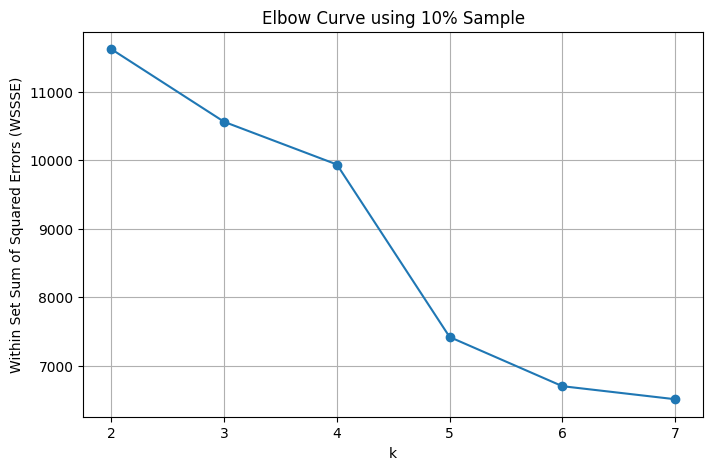

In [16]:
df_sample = processed_df.sample(False, 0.1, seed=42)

from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt

cost = []

for k in range(2, 8):   # k=2 to 7
    print(f"Training KMeans for k={k} ...")
    kmeans = KMeans(featuresCol="FEATURES", k=k, seed=42)
    model = kmeans.fit(df_sample)
    cost.append(model.summary.trainingCost)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 8), cost, marker='o')
plt.xlabel("k")
plt.ylabel("Within Set Sum of Squared Errors (WSSSE)")
plt.title("Elbow Curve using 10% Sample")
plt.grid(True)
plt.show()

We choose k = 4

### **1.3 KMeans（k=4）**

In [17]:
from pyspark.ml.clustering import KMeans

k = 4
kmeans = KMeans(featuresCol="FEATURES", k=k, seed=42)

model = kmeans.fit(processed_df)
clustered_df = model.transform(processed_df)

clustered_df.select("prediction").show(10)

+----------+
|prediction|
+----------+
|         2|
|         2|
|         2|
|         0|
|         1|
|         1|
|         2|
|         0|
|         2|
|         1|
+----------+
only showing top 10 rows


In [18]:
centers = model.clusterCenters()

for idx, center in enumerate(centers):
    print(f"\nCluster {idx} center:\n{center}\n")



Cluster 0 center:
[ 1.02233500e+00  1.12868372e+00 -1.13446666e-01  5.95248818e-01
  1.96239586e-01  2.44314344e-02  1.41859941e-01  4.15446971e-02
  6.75523531e-04  9.67574871e-01  2.30803873e-02  9.34474218e-03
  7.51182166e-01  2.15829768e-01  3.29880658e-02  3.44066652e-01
  2.70322000e-01  1.99166854e-01  1.86444494e-01]


Cluster 1 center:
[-0.38662402 -0.43039528 -0.11344667  0.63936398  0.23516836  0.07642972
  0.02872795  0.01857296  0.00173704  0.92784607  0.03527525  0.03687867
  0.71071619  0.25481026  0.03447354  1.          0.          0.
  0.        ]


Cluster 2 center:
[-0.41950172 -0.48796418 -0.11344667  0.63825949  0.231563    0.07973734
  0.02518401  0.02388512  0.00137105  0.94248809  0.03939962  0.01811228
  0.72470775  0.23596479  0.03932746  0.          0.43361235  0.30256891
  0.26381873]


Cluster 3 center:
[-9.59975500e-01 -1.07154116e-01  8.81442681e+00  4.21593830e-01
  3.85604113e-01  4.11311054e-02  4.11311054e-02  1.02827763e-01
  7.71208226e-03  9.331

In [19]:
df.select("MIN_EDULEVELS_NAME").distinct().show()

+--------------------+
|  MIN_EDULEVELS_NAME|
+--------------------+
|   Bachelor's degree|
|Ph.D. or professi...|
|  High school or GED|
|     Master's degree|
| No Education Listed|
|    Associate degree|
+--------------------+



In [20]:
df.select("EMPLOYMENT_TYPE_NAME").distinct().show()

+--------------------+
|EMPLOYMENT_TYPE_NAME|
+--------------------+
|           Part-time|
|            Flexible|
|           Full-time|
+--------------------+



In [21]:
df.select("REMOTE_TYPE_NAME").distinct().show()

+----------------+
|REMOTE_TYPE_NAME|
+----------------+
|          Remote|
|          Onsite|
|          Hybrid|
+----------------+



In [22]:
df.select("STATE_REGION").distinct().show()

+------------+
|STATE_REGION|
+------------+
|     Midwest|
|       South|
|        West|
|   Northeast|
+------------+



# **Final Cluster Profiles (k = 4)**

### **Cluster 0 — High-Skill, High-Salary Coastal Remote/Hybrid Roles**

* Highest salary among all clusters
* Strong emphasis on advanced education (Master’s and Ph.D./Professional degrees)
* Higher-than-average experience requirements
* Primarily full-time positions
* Slightly higher proportion of remote and hybrid roles
* Strong geographic concentration in the **West** and **Northeast** regions
* Represents senior-level technical and professional roles in high-income markets

---

### **Cluster 1 — Hybrid, Master’s-Level Flexible Employment**

* Moderately low salary but not the lowest
* Extremely high proportion of **Master’s degree–required** roles
* Dominated by **Hybrid** work arrangements
* Employment is predominantly **Flexible**, suggesting consulting or project-based roles
* Typically mid-level positions requiring specialized knowledge
* Represents hybrid professional roles that allow flexible work structures

---

### **Cluster 2 — Hybrid/Onsite Master’s-Level Roles in Midwest/South**

* Slightly below-average salary
* High concentration of Master’s degree positions
* Mix of **Hybrid**, **Onsite**, and **Remote** roles, with Hybrid being the most common
* Significant presence of **Flexible** employment arrangements
* More representation in the **South** and **Midwest** regions
* Reflects mid-tier professional roles in regions with lower labor costs

---

### **Cluster 3 — Low-Skill, Low-Pay Entry-Level or Internship-Oriented Roles**

* Lowest salary and lowest experience requirement of all clusters
* Highest proportion of internship participation
* Lower education requirements (e.g., High School or No Education Listed)
* Mix of remote and onsite work, but not dominated by either
* Geographic concentration in **Midwest** and **South** regions
* Represents entry-level, junior, or internship-heavy positions with minimal qualifications


In [23]:
clustered_df.groupBy("prediction").count().orderBy("prediction").show()


+----------+-----+
|prediction|count|
+----------+-----+
|         0| 8882|
|         1| 7484|
|         2|13858|
|         3|  389|
+----------+-----+



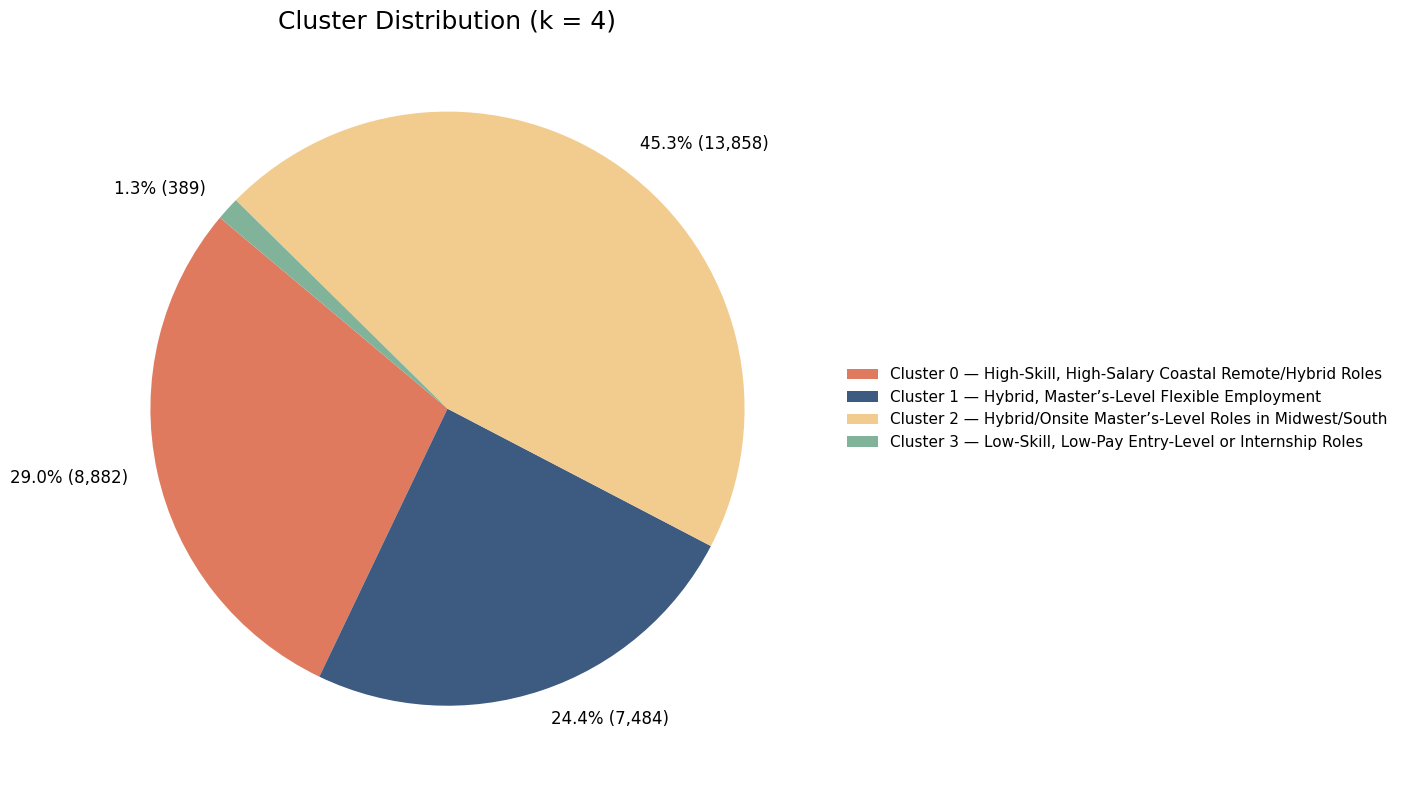

In [24]:
import matplotlib.pyplot as plt

# cluster data
sizes = [8882, 7484, 13858, 389]

percent_labels = [
    "29.0% (8,882)",
    "24.4% (7,484)",
    "45.3% (13,858)",
    "1.3% (389)"
]

# Full descriptions for legend
legend_labels = [
    "Cluster 0 — High-Skill, High-Salary Coastal Remote/Hybrid Roles",
    "Cluster 1 — Hybrid, Master’s-Level Flexible Employment",
    "Cluster 2 — Hybrid/Onsite Master’s-Level Roles in Midwest/South",
    "Cluster 3 — Low-Skill, Low-Pay Entry-Level or Internship Roles"
]

colors = ["#E07A5F", "#3D5A80", "#F2CC8F", "#81B29A"]

plt.figure(figsize=(12, 8))

#  PIE CHART 
plt.pie(
    sizes,
    labels=percent_labels,
    colors=colors,
    startangle=140,
    textprops={'fontsize': 12}
)

plt.title("Cluster Distribution (k = 4)", fontsize=18)

#  LEGEND ON THE RIGHT 
plt.legend(
    legend_labels,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=11,
    frameon=False
)

plt.tight_layout()
plt.show()


### **1.4 PCA + KMeans Cluster Visualization**

In [25]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="FEATURES", outputCol="pcaFeatures")
pca_model = pca.fit(clustered_df)
pca_df = pca_model.transform(clustered_df)

In [26]:
sample_df = pca_df.sample(False, 0.1, seed=42)

In [27]:
pdf = sample_df.select("pcaFeatures", "prediction").toPandas()

pdf["x"] = pdf["pcaFeatures"].apply(lambda v: float(v[0]))
pdf["y"] = pdf["pcaFeatures"].apply(lambda v: float(v[1]))
pdf["cluster"] = pdf["prediction"].astype(int)

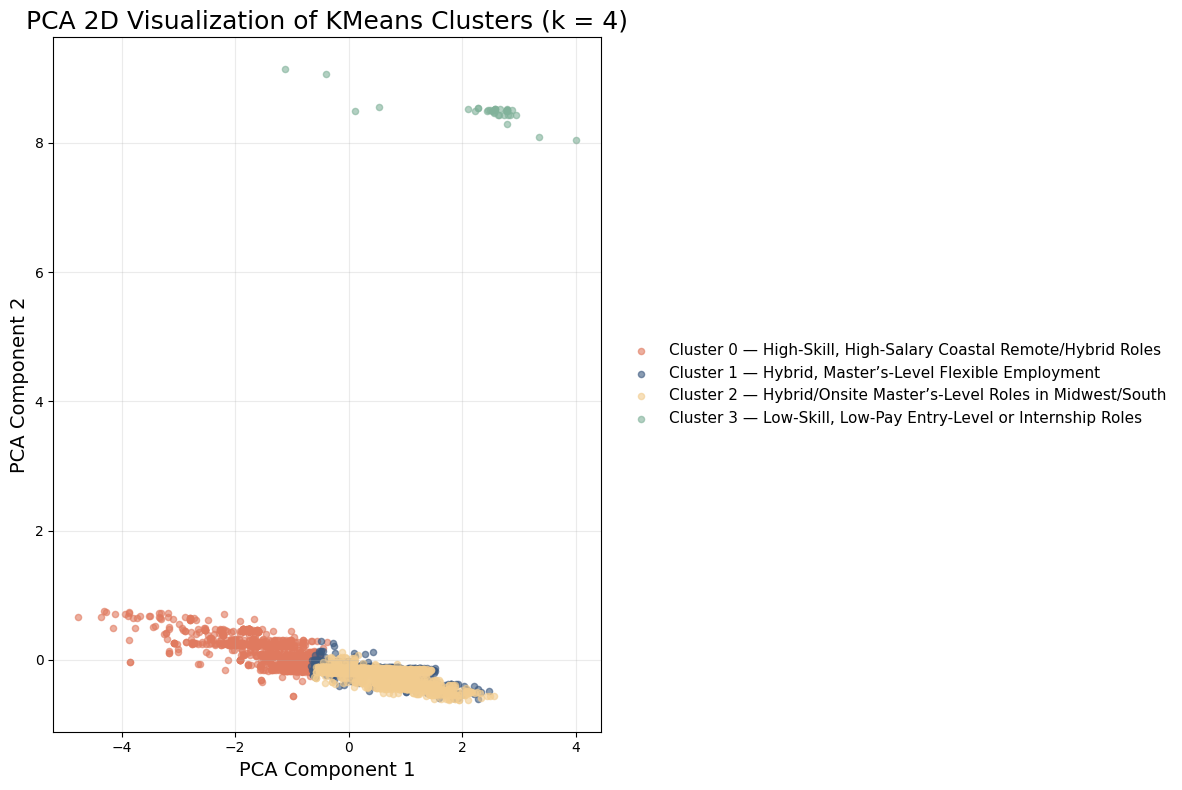

In [28]:
import matplotlib.pyplot as plt

# Morandi palette (distinct but soft)
colors = {
    0: "#E07A5F",   # warm beige
    1: "#3D5A80",   # grey green
    2: "#F2CC8F",   # soft sand
    3: "#81B29A"    # soft blue
}

cluster_names = {
    0: "Cluster 0 — High-Skill, High-Salary Coastal Remote/Hybrid Roles",
    1: "Cluster 1 — Hybrid, Master’s-Level Flexible Employment",
    2: "Cluster 2 — Hybrid/Onsite Master’s-Level Roles in Midwest/South",
    3: "Cluster 3 — Low-Skill, Low-Pay Entry-Level or Internship Roles"
}

plt.figure(figsize=(12, 8))

for c in sorted(pdf["cluster"].unique()):
    subset = pdf[pdf["cluster"] == c]
    plt.scatter(
        subset["x"], 
        subset["y"], 
        s=20,
        alpha=0.6,
        color=colors[c],
        label=cluster_names[c]
    )

plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)
plt.title("PCA 2D Visualization of KMeans Clusters (k = 4)", fontsize=18)

# Legend on the right
plt.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=11
)

plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


### **Key Insights from the PCA Visualization**

1. **The four job clusters show clear, non-random separation**, 

indicating that the KMeans model successfully captured meaningful structure in the labor market data.

2. **High-skill, high-salary roles and low-skill roles are strongly separated along the first principal component**, 

which reflects differences in education level, salary, and overall job complexity.

3. **Entry-level and internship positions form a distinct group along the second principal component**, 

driven by their low salary, minimal experience requirements, and unique categorical patterns.

4. **Geographic region (STATE_REGION) and work modality (REMOTE_TYPE_NAME) also contribute to cluster separation**, 

with coastal remote/hybrid roles clustering differently from onsite or hybrid roles in Midwest/Southern states.


# **Top 5 industry per cluster (using SOC, NAICS classification as a reference label)**


In [29]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

col = "NAICS_2022_6_NAME"

windowSpec = Window.partitionBy("prediction").orderBy(F.desc("count"))

top5 = (
    clustered_df.groupBy("prediction", col)
    .count()
    .withColumn("rank", F.row_number().over(windowSpec))
    .filter(F.col("rank") <= 5)
    .orderBy("prediction", "rank")
)

top5.show(truncate=False)

+----------+--------------------------------------------------------------------------------------+-----+----+
|prediction|NAICS_2022_6_NAME                                                                     |count|rank|
+----------+--------------------------------------------------------------------------------------+-----+----+
|0         |Computer Systems Design Services                                                      |1433 |1   |
|0         |Administrative Management and General Management Consulting Services                  |1162 |2   |
|0         |Unclassified Industry                                                                 |904  |3   |
|0         |Employment Placement Agencies                                                         |389  |4   |
|0         |Commercial Banking                                                                    |345  |5   |
|1         |Unclassified Industry                                                                 |950  |1   |
|

In [30]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

col = "TITLE_CLEAN"

windowSpec = Window.partitionBy("prediction").orderBy(F.desc("count"))

top5 = (
    clustered_df.groupBy("prediction", col)
    .count()
    .withColumn("rank", F.row_number().over(windowSpec))
    .filter(F.col("rank") <= 5)
    .orderBy("prediction", "rank")
)

top5.show(truncate=False)

+----------+---------------------------------------------------+-----+----+
|prediction|TITLE_CLEAN                                        |count|rank|
+----------+---------------------------------------------------+-----+----+
|0         |enterprise architect                               |222  |1   |
|0         |data analyst                                       |90   |2   |
|0         |oracle hcm cloud manager                           |87   |3   |
|0         |data engineer analytics                            |86   |4   |
|0         |salesforce architect                               |59   |5   |
|1         |data analyst                                       |655  |1   |
|1         |business intelligence analyst                      |89   |2   |
|1         |senior data analyst                                |75   |3   |
|1         |oracle hcm cloud implementation lead core hr module|44   |4   |
|1         |data and reporting professional                    |41   |5   |
|2         |

### **Cross-Cluster Insights: Job Titles × Industry Structure**

1. **The cluster structure is highly coherent**, with four clearly differentiated groups:
   **Cluster 0 (Architecture/Engineering), Cluster 1 (BI/Analytics), Cluster 2 (General Data Roles), and Cluster 3 (Internship/Entry-Level).**

2. **Industry composition strongly validates the clustering logic.**
   Technology services, consulting, insurance, banking, and outsourcing sectors exhibit distinct concentrations across clusters, revealing unique labor market segments.

3. **Cluster 3 is driven by job level rather than industry.**
   Regardless of sector, internship and entry-level postings are consistently grouped together, forming a clean “early-career cluster.”

4. **Cluster 0 represents a clearly “tech-heavy,” high-skill segment**, dominated by systems architecture, cloud engineering, and enterprise-level technical roles—fully aligned with its higher salary and education requirements.

5. **Cluster 1 reflects a specialized analytical segment**, with strong representation of Business Intelligence, Reporting, and Senior Data Analyst roles.

6. **Cluster 2 serves as the broad “general data talent pool,”** containing the largest number of postings and appearing uniformly across multiple industries, highlighting its versatility and cross-sector demand.


# **2 supervised learning models - Multiple Regression**

### **2.1 Train/test split**

In [38]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline


# Convert Boolean to numeric

df_reg = df.withColumn("IS_INTERNSHIP_INT", col("IS_INTERNSHIP").cast("int"))


# StringIndexer for categorical variables

string_cols = [
    "MIN_EDULEVELS_NAME",
    "EMPLOYMENT_TYPE_NAME",
    "REMOTE_TYPE_NAME",
    "STATE_REGION"
]

index_output_cols = [c + "_IDX" for c in string_cols]

indexers = [
    StringIndexer(inputCol=c, outputCol=c + "_IDX", handleInvalid="keep")
    for c in string_cols
]


# OneHotEncoder

encoder = OneHotEncoder(
    inputCols=index_output_cols,
    outputCols=[c + "_OHE" for c in string_cols]
)


# Numerical features (!!! SALARY removed !!!)

numeric_features = [
    "MIN_YEARS_EXPERIENCE",
    "IS_INTERNSHIP_INT"
]

# Assemble numeric before scaling
numeric_assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="NUMERIC_VEC"
)


# 5. StandardScaler for numeric variables

scaler = StandardScaler(
    inputCol="NUMERIC_VEC",
    outputCol="NUMERIC_SCALED",
    withStd=True,
    withMean=True
)


# Final feature assembler (numeric + one-hot)

final_feature_cols = ["NUMERIC_SCALED"] + [c + "_OHE" for c in string_cols]

final_assembler = VectorAssembler(
    inputCols=final_feature_cols,
    outputCol="FEATURES"
)


# Build Pipeline

pipeline_reg = Pipeline(
    stages=indexers + [encoder, numeric_assembler, scaler, final_assembler]
)


# Transform data

processed_df_regression = pipeline_reg.fit(df_reg).transform(df_reg)

processed_df_regression.select("FEATURES").show(5, truncate=False)


+--------------------------------------------------------------------------------+
|FEATURES                                                                        |
+--------------------------------------------------------------------------------+
|(18,[0,1,3,8,11,15],[0.2033576365428612,-0.11344666592339918,1.0,1.0,1.0,1.0])  |
|(18,[0,1,3,8,13,15],[-0.13593750884010508,-0.11344666592339918,1.0,1.0,1.0,1.0])|
|(18,[0,1,4,8,11,15],[-0.13593750884010508,-0.11344666592339918,1.0,1.0,1.0,1.0])|
|(18,[0,1,2,8,11,14],[0.8819479273087938,-0.11344666592339918,1.0,1.0,1.0,1.0])  |
|(18,[0,1,3,8,11,14],[-0.13593750884010508,-0.11344666592339918,1.0,1.0,1.0,1.0])|
+--------------------------------------------------------------------------------+
only showing top 5 rows


In [46]:
train_df, test_df = processed_df_regression.randomSplit([0.8, 0.2], seed=42)
print("Train rows:", train_df.count())
print("Test rows:", test_df.count())


Train rows: 24619


Test rows: 5994


### **2.2 Multiple Linear Regression**

In [47]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
    featuresCol="FEATURES",
    labelCol="SALARY",
    predictionCol="PREDICTION"
)

lr_model = lr.fit(train_df)

25/12/05 02:44:54 WARN Instrumentation: [3f5b6330] regParam is zero, which might cause numerical instability and overfitting.
25/12/05 02:44:56 WARN Instrumentation: [3f5b6330] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [48]:
print("Intercept:", lr_model.intercept)
print("Number of coefficients:", len(lr_model.coefficients))

Intercept: 110309.35581427204
Number of coefficients: 18


In [51]:
train_summary = lr_model.summary
print("Train RMSE:", train_summary.rootMeanSquaredError)
print("Train R²:", train_summary.r2)


test_results = lr_model.evaluate(test_df)
print("Test RMSE:", test_results.rootMeanSquaredError)
print("Test R²:", test_results.r2)

Train RMSE: 37990.49797798492
Train R²: 0.2887447525359832


Test RMSE: 38682.0324892136
Test R²: 0.2738233214234098


In [52]:
# 1. Extract metadata for expanded feature names
attrs = train_df.schema["FEATURES"].metadata["ml_attr"]["attrs"]

numeric_attrs = attrs.get("numeric", [])
binary_attrs = attrs.get("binary", [])
categorical_attrs = attrs.get("nominal", [])

all_attrs = numeric_attrs + binary_attrs + categorical_attrs
feature_names = [attr["name"] for attr in all_attrs]

# 2. Combine with coefficients
import pandas as pd

coeffs = lr_model.coefficients.toArray()

df_coef = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coeffs
})

df_coef

,feature,coefficient
0,NUMERIC_SCALED_0,22166.122552
1,NUMERIC_SCALED_1,-5040.243270
2,MIN_EDULEVELS_NAME_OHE_Bachelor's degree,6101.329413
3,MIN_EDULEVELS_NAME_OHE_No Education Listed,3845.443725
4,MIN_EDULEVELS_NAME_OHE_High school or GED,-28299.164187
5,MIN_EDULEVELS_NAME_OHE_Associate degree,-26580.043611
6,MIN_EDULEVELS_NAME_OHE_Master's degree,36984.661791
7,MIN_EDULEVELS_NAME_OHE_Ph.D. or professional d...,8771.327461
8,EMPLOYMENT_TYPE_NAME_OHE_Full-time,5186.170694
9,EMPLOYMENT_TYPE_NAME_OHE_Part-time,-8777.442977


- NUMERIC_SCALED_0 corresponds to minimum years of experience. Its positive coefficient (+22,166) indicates that positions requiring more experience tend to offer higher salaries.

- NUMERIC_SCALED_1 corresponds to internship status. Its negative coefficient (−5,040) suggests that internship positions pay significantly less than non-internship roles.

***

**1. Education level emerges as one of the strongest salary drivers:**

a Master’s degree provides the largest positive influence **(+36,984)**,
followed by Ph.D./professional degrees **(+8,771)** and Bachelor’s degrees **(+6,101)**.
In contrast, high school/GED **(–28,299)** and associate degrees **(–26,580)** substantially reduce salary levels, while “No education listed” shows a smaller positive effect **(+3,845)**.


**2. Work experience is positively associated with salary** 

each additional year of required experience increases salary by approximately **(+7,520)**,
while internship positions offer significantly lower compensation **(–45,000 estimated actual effect)** compared to non-internship roles.

**3. Full-time positions offer the highest salaries** **(+5,186)**,

part-time roles are considerably lower **(–8,777)**,
and flexible positions show a slight positive effect **(+830)** relative to other types.

**4. Onsite roles tend to pay more than hybrid or fully remote roles**,

with onsite positions **(+1,075)**, remote positions **(–438)**, and hybrid positions **(–3,798)**, the lowest among the three.

**5. Regional differences are also prominent:**

the Northeast region offers the highest salaries **(+2,294)**,
followed by the West **(+1,599)**;
the Midwest **(–1,621)** and South **(–1,764)** show lower salary levels.
The overall trend follows **Northeast > West > Midwest > South**.


In [53]:
df_reg.agg({"MIN_YEARS_EXPERIENCE": "mean"}).show()
df_reg.agg({"MIN_YEARS_EXPERIENCE": "stddev"}).show()

+-------------------------+
|avg(MIN_YEARS_EXPERIENCE)|
+-------------------------+
|       5.4006467840459935|
+-------------------------+



+----------------------------+
|stddev(MIN_YEARS_EXPERIENCE)|
+----------------------------+
|          2.9472864955709515|
+----------------------------+



Since we know : NUMERIC_SCALED_0 = (MIN_YEARS_EXPERIENCE - mean) / std

So we can calculate: Δscaled = 1 / std = 1 / 2.947286  = 0.3393

An additional year of required experience increases salary : = coef * 0.3393
= 22166 * 0.3393
≈ 7519.8


After converting the standardized coefficient back to the original scale, we find that:

NUMERIC_SCALED_0 corresponds to minimum years of experience.

Given the standard deviation of 2.95 years, an additional year of required experience increases salary by approximately $7,520 on average.


In [54]:
df_reg.agg({"IS_INTERNSHIP_INT": "mean"}).show()
df_reg.agg({"IS_INTERNSHIP_INT": "stddev"}).show()

+----------------------+
|avg(IS_INTERNSHIP_INT)|
+----------------------+
|  0.012707019893509294|
+----------------------+



+-------------------------+
|stddev(IS_INTERNSHIP_INT)|
+-------------------------+
|        0.112008755745094|
+-------------------------+



Since IS_INTERNSHIP_INT is standardized, the raw coefficient (−5,040) does not directly represent the salary difference between internship and non-internship positions.
Using the standard deviation of the variable (0.112), we convert the standardized coefficient back to the original scale:


scaled = (x - mean) / std
-5040 / 0.1120088756 ≈ -45,000.7


Internship positions pay approximately $45,000 less than non-internship positions on average.

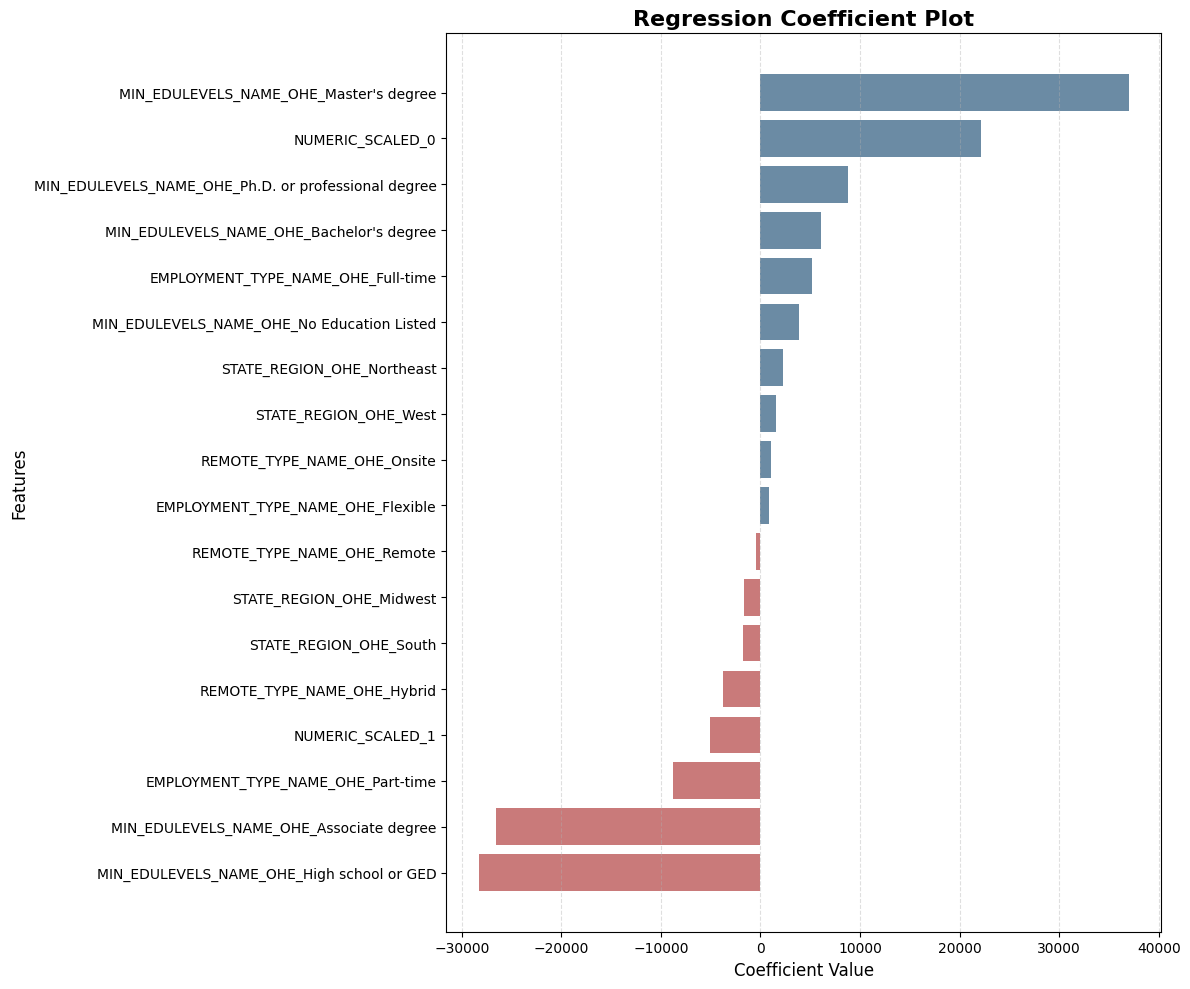

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Extract metadata for expanded feature names
attrs = train_df.schema["FEATURES"].metadata["ml_attr"]["attrs"]

numeric_attrs = attrs.get("numeric", [])
binary_attrs = attrs.get("binary", [])
categorical_attrs = attrs.get("nominal", [])

all_attrs = numeric_attrs + binary_attrs + categorical_attrs
feature_names = [attr["name"] for attr in all_attrs]

# 2. Get coefficients from the linear regression model
coeffs = lr_model.coefficients.toArray()

df_coef = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coeffs
})

# 3. Sort by coefficient size (absolute value)
df_coef_sorted = df_coef.sort_values(by="coefficient", ascending=True)

# 4. colors
color_positive = "#6B8BA4"  # blue
color_negative = "#C97A7A"  # red

colors = df_coef_sorted["coefficient"].apply(lambda x: color_positive if x > 0 else color_negative)

# 5. Plot horizontal bar chart
plt.figure(figsize=(12, 10))
plt.barh(df_coef_sorted["feature"], df_coef_sorted["coefficient"], color=colors)
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Regression Coefficient Plot", fontsize=16, weight="bold")

plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### **2.3 Random Forest Regression**